In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## install required packages
!pip install gym
!pip install stockstats
!pip install gymnasium
!pip install stable_baselines3
!pip install alpaca_trade_api
!pip install exchange_calendars
!pip install pyfolio
!pip install matplotlib
!pip install swig
!pip install wrds
!pip install pyportfolioopt
!pip install --upgrade ipykernel
## install finrl library
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 44.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 17.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [35]:
import sys
sys.path.append("/content/drive/MyDrive/kubig_financial/finrl")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from stable_baselines3.common.vec_env import DummyVecEnv


from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

In [36]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
) # 각 종 parameter들이 정의되어 있다.
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [37]:
# from config.py, TRAIN_START_DATE is a string
print(TRAIN_START_DATE)
# from config.py, TRAIN_END_DATE is a string
print(TRAIN_END_DATE)

2014-01-06
2020-07-31


In [38]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-05'

In [39]:
tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

In [40]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = tickers).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30213, 8)


In [41]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.364515,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,37.747688,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.344019,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.793041,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.110197,8449400,XLK,0


In [42]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.364515,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,37.747688,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.344019,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.793041,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.110197,8449400,XLK,0


In [43]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [44]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)
# 각 timestep에 지표들을 달아준다.
processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3356, 8)
Successfully added vix
Successfully added turbulence index


In [45]:
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,33.580002,34.020000,33.450001,25.364515,7567500,XLB,0,0.0,25.521504,25.289539,100.0,66.666667,100.0,25.364515,25.364515,20.040001,0.0
1,2010-01-04,57.919998,58.810001,57.790001,37.747688,16928400,XLE,0,0.0,25.521504,25.289539,100.0,66.666667,100.0,37.747688,37.747688,20.040001,0.0
2,2010-01-04,11.795288,11.965881,11.770918,9.344019,92942347,XLF,0,0.0,25.521504,25.289539,100.0,66.666667,100.0,9.344019,9.344019,20.040001,0.0
3,2010-01-04,28.090000,28.320000,27.959999,21.793041,7471500,XLI,0,0.0,25.521504,25.289539,100.0,66.666667,100.0,21.793041,21.793041,20.040001,0.0
4,2010-01-04,23.139999,23.290001,23.100000,19.110197,8449400,XLK,0,0.0,25.521504,25.289539,100.0,66.666667,100.0,19.110197,19.110197,20.040001,0.0


In [46]:
#prediction 데이터 통합

prediction_dataset = pd.read_csv('/content/drive/MyDrive/kubig_financial/dataset/DLinear_prediction.csv')
prediction_dataset.drop('Unnamed: 0', axis=1, inplace=True)

#transform the dataframe to date, tic, close format
prediction_dataset = pd.melt(prediction_dataset, id_vars=['date'], value_vars=tickers)
prediction_dataset = prediction_dataset.rename(columns={'variable': 'tic', 'value': 'prediction'})

#transform the dataframe ordered by date
prediction_dataset = prediction_dataset.sort_values(['date','tic'],ignore_index=True)
prediction_dataset

,date,tic,prediction
0,2010-04-19,XLB,25.859594
1,2010-04-19,XLE,39.087642
2,2010-04-19,XLF,10.522497
3,2010-04-19,XLI,24.194782
4,2010-04-19,XLK,19.711333
...,...,...,...
29542,2023-05-01,XLK,145.494752
29543,2023-05-01,XLP,74.473373
29544,2023-05-01,XLU,68.541341
29545,2023-05-01,XLV,132.607725


In [47]:
prediction_dataset.iloc[1]['date']

'2010-04-19'

In [48]:
total_date = set(processed['date'])

for i in range(len(prediction_dataset)):
  if prediction_dataset.iloc[i]['date'] not in total_date:
    prediction_dataset.drop(i, axis=0, inplace=True)

In [49]:
processed_full = pd.merge(processed, prediction_dataset, on=['date','tic'], how='left')
processed_full.dropna(inplace=True)
processed_full.iloc[100:120]
processed_full

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,prediction
648,2010-04-19,34.070000,34.389999,33.740002,25.658653,11292900,XLB,0,0.306560,26.436506,24.986163,55.358536,13.083834,12.195154,25.432503,24.438956,17.34,0.000000,25.859594
649,2010-04-19,58.759998,59.400002,58.580002,38.247009,21149100,XLE,0,0.439197,39.516718,35.867478,55.374614,51.659578,7.922057,37.595105,36.802639,17.34,0.000000,39.087642
650,2010-04-19,13.135662,13.444354,13.119415,10.531995,319699563,XLF,0,0.222585,10.849696,9.914020,62.673062,64.486368,2.919068,10.226858,9.675608,17.34,0.000000,10.522497
651,2010-04-19,32.060001,32.150002,31.730000,24.732454,16021200,XLI,0,0.435005,25.096905,23.686948,66.023338,93.555160,26.560540,24.066753,22.906683,17.34,0.000000,24.194782
652,2010-04-19,23.690001,23.820000,23.520000,19.591213,8766800,XLK,0,0.285344,19.772661,18.707008,62.997402,126.710776,20.868459,19.057629,18.386408,17.34,0.000000,19.711333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30190,2023-05-01,150.710007,151.649994,150.470001,150.604538,4097200,XLK,0,1.239395,151.683997,144.862858,58.792185,130.194761,22.022560,147.382295,143.241942,16.08,5.148513,145.494752
30191,2023-05-01,77.309998,77.820000,77.290001,76.954063,10860800,XLP,0,0.950605,77.021046,73.860555,63.430220,135.317657,43.119261,74.514704,73.141218,16.08,5.148513,74.473373
30192,2023-05-01,68.820000,69.769997,68.760002,68.548637,10508100,XLU,0,0.527982,70.087593,67.158486,53.317069,51.484457,5.426603,67.570505,66.641524,16.08,5.148513,68.541341
30193,2023-05-01,133.720001,134.759995,133.460007,133.669754,6793900,XLV,0,1.038014,135.408295,130.515053,55.468008,65.987070,13.539273,130.906135,129.538939,16.08,5.148513,132.607725


In [50]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,prediction
0,2010-04-19,34.070000,34.389999,33.740002,25.658653,11292900,XLB,0,0.306560,26.436506,24.986163,55.358536,13.083834,12.195154,25.432503,24.438956,17.34,0.0,25.859594
1,2010-04-19,58.759998,59.400002,58.580002,38.247009,21149100,XLE,0,0.439197,39.516718,35.867478,55.374614,51.659578,7.922057,37.595105,36.802639,17.34,0.0,39.087642
2,2010-04-19,13.135662,13.444354,13.119415,10.531995,319699563,XLF,0,0.222585,10.849696,9.914020,62.673062,64.486368,2.919068,10.226858,9.675608,17.34,0.0,10.522497
3,2010-04-19,32.060001,32.150002,31.730000,24.732454,16021200,XLI,0,0.435005,25.096905,23.686948,66.023338,93.555160,26.560540,24.066753,22.906683,17.34,0.0,24.194782
4,2010-04-19,23.690001,23.820000,23.520000,19.591213,8766800,XLK,0,0.285344,19.772661,18.707008,62.997402,126.710776,20.868459,19.057629,18.386408,17.34,0.0,19.711333
5,2010-04-19,27.850000,28.030001,27.830000,19.610168,4791100,XLP,0,0.102488,19.727476,19.468360,59.912353,35.391934,13.586302,19.490739,19.049358,17.34,0.0,19.789617
6,2010-04-19,29.780001,29.920000,29.680000,18.733133,5285500,XLU,0,0.067682,19.176018,18.406928,49.825370,-46.885871,15.405114,18.762874,18.536947,17.34,0.0,19.119324
7,2010-04-19,31.629999,31.920000,31.520000,25.417498,11270000,XLV,0,-0.007597,25.954186,25.221152,50.763019,-111.071373,22.661617,25.543932,25.236940,17.34,0.0,25.940861
8,2010-04-19,34.299999,34.520000,33.930000,28.949383,9300300,XLY,0,0.607512,29.344087,27.070640,71.945242,120.863010,30.974354,27.814798,26.404187,17.34,0.0,30.204356
9,2010-04-20,34.610001,34.720001,34.299999,25.740843,5805300,XLB,1,0.277923,26.426029,25.047448,56.020227,52.843546,2.908948,25.466172,24.474927,15.73,0.0,25.886425


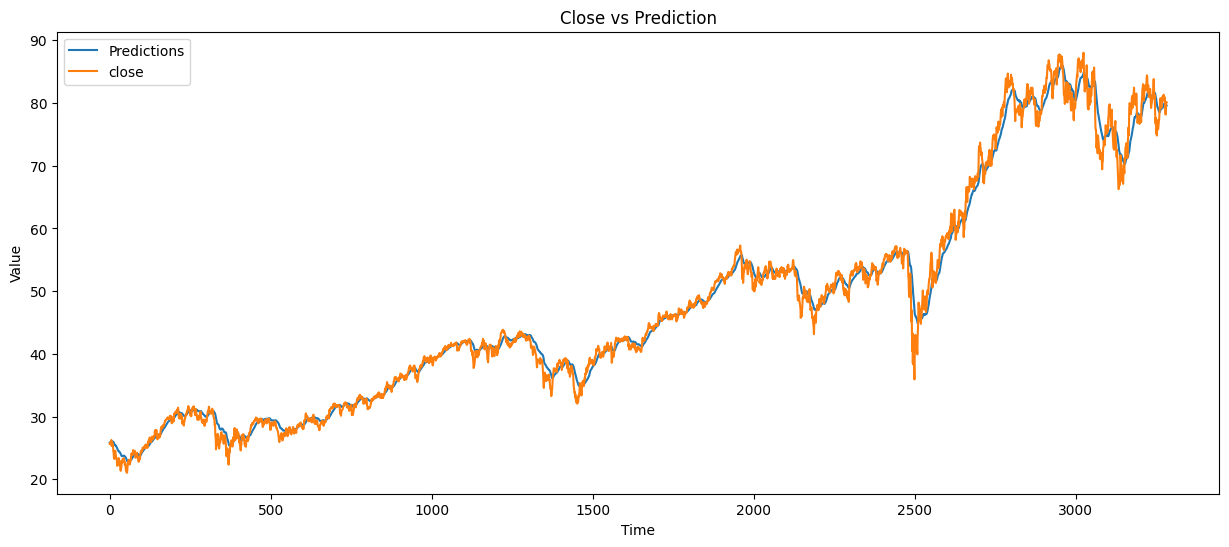

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

prediction = processed_full[processed_full['tic']=='XLB']['prediction'].values
close = processed_full[processed_full['tic']=='XLB']['close'].values

plt.figure(figsize=(15, 6))
plt.plot(prediction, label='Predictions')
# Plot predictions
plt.plot(close, label='close')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Close vs Prediction')
plt.legend()
plt.show()

In [52]:
INDICATORS = INDICATORS + ['prediction']

In [53]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

25965
3582


In [54]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension #현재 상태를 나타내는 state를 정의. 1+ ticker 개수 x2 + 인디케이터 개수 x ticker개수
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 9, State Space: 100


In [55]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [56]:
print(buy_cost_list)
num_stock_shares

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [57]:
env_train = DummyVecEnv([lambda: e_train_gym]) ### fixed
# env_train, _ = e_train_gym.get_sb_env()
# env_train.reset()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [58]:
agent = DRLAgent(env = env_train)

if_using_a2c = True ##a2c만 사용해보자
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = False

In [29]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [30]:
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c', total_timesteps=50000) if if_using_a2c else None

-------------------------------------
| time/                 |           |
|    fps                | 109       |
|    iterations         | 100       |
|    time_elapsed       | 4         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -12.9     |
|    explained_variance | -0.785    |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 0.148     |
|    reward             | 1.1751138 |
|    std                | 1.01      |
|    value_loss         | 0.479     |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 139       |
|    iterations         | 200       |
|    time_elapsed       | 7         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -12.8     |
|    explained_variance | -0.0395   |
|    learning_rate      | 0.0007    |
|    n_updat

In [33]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [34]:
trained_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_model,
    environment = e_trade_gym)

ValueError: ignored

In [ ]:
df_account_value_a2c.shape

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_account_value_a2c.to_csv("/content/drive/MyDrive/kubig_financial/result/df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame(df_result_a2c)

"""result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, left_index=True, right_index=True)
result = pd.merge(result, MVO_result, left_index=True, right_index=True)"""
result = pd.merge(result, df_dji, left_index=True, right_index=True)


result.columns = ['a2c','dji']

print("result: ", result)
result.to_csv("/content/drive/MyDrive/kubig_financial/result/result.csv")

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [ ]:
df_result_a2c.iloc[-1,0]

In [ ]:
print('A2C로 얻은 투자 수익률>>', round((df_result_a2c.iloc[-1,0]/df_result_a2c.iloc[0,0]-1)*100,2),'%')

In [ ]:
df_daily_return = df_account_value_a2c
df_daily_return

In [ ]:
df_actions_a2c